In [1]:
# Exploring the covariance in segregating sites
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
from tqdm import tqdm

import os
import sys
sys.path.append('../../src/')
from aDNA_coal_sim import SerialConstant, SerialBottleneck
from plot_utils import *

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['figure.facecolor'] = "w"
plt.rcParams['figure.autolayout'] = True

main_figdir = '../../plots/supp_figs/hap_copying/'
os.makedirs(main_figdir, exist_ok=True)

In [3]:
# Defining functions to run simulations and extract summary stats
def extract_time_first_coal_ancients(ts):
    t1 = ts.first()
    t1 = ts.first()
    mod_samples = []
    anc_samples = []
    for i in ts.samples():
        if t1.time(i) != 0:
            anc_samples.append((i,t1.time(i)))
        else:
            mod_samples.append(i)
    anc_samples_ext_bl = []
    for x in anc_samples:
        min_tmrca = np.min([t1.tmrca(x[0], j) for j in mod_samples])
        ext_bl = (min_tmrca - x[1])
        anc_samples_ext_bl.append([x[1], ext_bl])
    anc_samples_ext_bl = np.vstack(anc_samples_ext_bl)
    return(anc_samples_ext_bl)

def group_df_test(np_sims):
    test_df = pd.DataFrame(np_sims)
    test_df.columns = ['t_a', 't_star']
    group_df = test_df.groupby('t_a', as_index=False).agg({'t_star': ['mean', 'sem']})
    return(group_df)


In [4]:
# Parameter Settings
K=50
t_a_max = 400
interval = 20
n_a = 1
t_anc = np.arange(interval, t_a_max+1, interval).tolist()
n_anc = np.repeat(n_a, len(t_anc)).tolist()

# Constant population size simulations
const_sim  = SerialConstant(Ne=1e4, mod_n=K, t_anc=t_anc, n_anc=n_anc)


# Bottleneck simulations 
bott_sim = SerialBottleneck(Ne=1e6, mod_n=K, t_anc=t_anc, n_anc=n_anc, 
                            bottle_start=400, bottle_duration=int(5e5), bottle_mag=0.01)


# Collecting $T^*$ estimates from simulations

In [5]:
ts_reps_constant = const_sim._simulate(num_replicates=5000, random_seed=42)
ts_reps_bottleneck = bott_sim._simulate(num_replicates=5000, random_seed=24)

t_first_coal_const = np.vstack([extract_time_first_coal_ancients(t) for t in tqdm(ts_reps_constant)])
t_first_coal_bottleneck = np.vstack([extract_time_first_coal_ancients(t) for t in tqdm(ts_reps_bottleneck)])

# Converting to a dataframe with means
test_serial_const_df = group_df_test(t_first_coal_const)
test_serial_bott_df = group_df_test(t_first_coal_bottleneck)

5000it [00:12, 414.45it/s]
5000it [00:12, 404.22it/s]


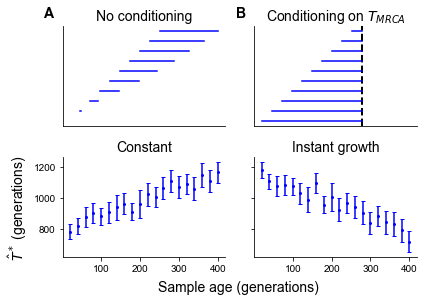

In [6]:
fig, ax = plt.subplots(2,2,figsize=(6,4), sharex='row', sharey='row')

tas = np.arange(0, 1.0, 0.1)
#Plot 1: not conditional on the TMRCA
i = 0
for t in tas:
    ax[0,0].plot([t,t+np.exp(-5e-1/(t+1e-6))], [i,i], color='blue')
    i += 0.5

#Plot 2: conditional on TMRCA of system
ax[0,1].axvline(x=1.0, linestyle='--', color='black', lw=2)
i = 0
for t in tas:
    ax[0,1].plot([t,1.0], [i,i], color='blue')
    i += 0.5
    
ax[0,0].set_yticks([]); ax[0,1].set_yticks([]);
ax[0,0].set_xticks([]); ax[0,1].set_xticks([]);

ax[0,0].set_title(r'No conditioning', fontsize=14)
ax[0,1].set_title(r'Conditioning on $T_{MRCA}$', fontsize=14)

# Actual Simulation Results
ax[1,0].errorbar(test_serial_const_df['t_a'].values, 
               test_serial_const_df['t_star']['mean'].values,
               yerr=2*test_serial_const_df['t_star']['sem'].values, 
                 marker='o', markersize=2, linestyle='none', capsize=2, color='blue')

ax[1,1].errorbar(test_serial_bott_df['t_a'].values,
               test_serial_bott_df['t_star']['mean'].values,
               yerr=2*test_serial_const_df['t_star']['sem'].values, 
                 marker='o', markersize=2, linestyle='none', capsize=2, color='blue')


ax[1,0].set_title(r'Constant', fontsize=14)
ax[1,1].set_title(r'Instant growth', fontsize=14)
ax[1,0].set_ylabel(r'$\hat{T}^*$ (generations)', fontsize=14)
fig.text(x=0.375, y=-0.025, s='Sample age (generations)', fontsize=14)

debox_all(ax[0,:]); debox_all(ax[1,:]);
label_multipanel(ax[0,:], ['A','B'], yoff=1.2, 
                 fontsize=14, fontweight='bold', va='top', ha='right')

plt.tight_layout()
plt.savefig(main_figdir + 't_star_coal.pdf', dpi=300, bbox_inches='tight')
plt.savefig(main_figdir + 't_star_coal.png', dpi=300, bbox_inches='tight')